# EDA: Univariate and multivariate **analysis**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('weatherAUS.csv')

# Summary statistics for numerical features
print(df.describe())

# Distribution plots for numerical features
for col in ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Count plots for categorical features
for col in ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']:
    plt.figure()
    sns.countplot(x=col, data=df)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=90)
    plt.show()


             MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.0000

In [ ]:
# Correlation matrix for numerical features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot for a few selected features
sns.pairplot(df[['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'Humidity9am', 'Humidity3pm', 'RainTomorrow']], hue='RainTomorrow')
plt.show()


# Data Preparation

In [ ]:
# Check for missing values
print(df.isnull().sum())
df.fillna(0, inplace=True)

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalizing numerical columns
scaler = MinMaxScaler()
num_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
# One-hot encoding for categorical columns
df = pd.get_dummies(df, columns=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])

In [ ]:
df['RainTomorrow'] = df['RainTomorrow'].replace({'No': 0, 'Yes': 1})
df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'])

# Modeling

## Logistic

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Splitting data
X = df.drop(['RainTomorrow', 'Date'], axis=1)
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Evaluation before tuning
y_pred = log_reg.predict(X_test)
print("Classification report before tuning:")
print(classification_report(y_test, y_pred))

# Hyperparameters Tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')

# Evaluation after tuning
y_pred_tuned = best_lr.predict(X_test)
print("Classification report after tuning:")
print(classification_report(y_test, y_pred_tuned))

# Compute ROC AUC score for the tuned model
y_pred_prob_tuned = best_lr.predict_proba(X_test)[:, 1]
roc_auc_tuned = roc_auc_score(y_test, y_pred_prob_tuned)
print(f"ROC AUC Score after tuning: {roc_auc_tuned}")

# Plot ROC Curve for the tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_prob_tuned)
plt.figure()
plt.plot(fpr_tuned, tpr_tuned, label='ROC curve (area = %0.2f)' % roc_auc_tuned)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic after Tuning')
plt.legend(loc="lower right")
plt.show()

# Coefficients Interpretation
importance = best_lr.coef_[0]
plt.bar(range(len(importance)), importance)
plt.show()


## KNN

Classification report before tuning:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     22672
           1       0.60      0.38      0.47      6420

    accuracy                           0.81     29092
   macro avg       0.72      0.66      0.68     29092
weighted avg       0.79      0.81      0.79     29092

Best parameters: {'n_neighbors': 2}
Classification report after tuning:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88     22672
           1       0.62      0.24      0.34      6420

    accuracy                           0.80     29092
   macro avg       0.72      0.60      0.61     29092
weighted avg       0.77      0.80      0.76     29092

ROC AUC Score after tuning: 0.7045551781933663


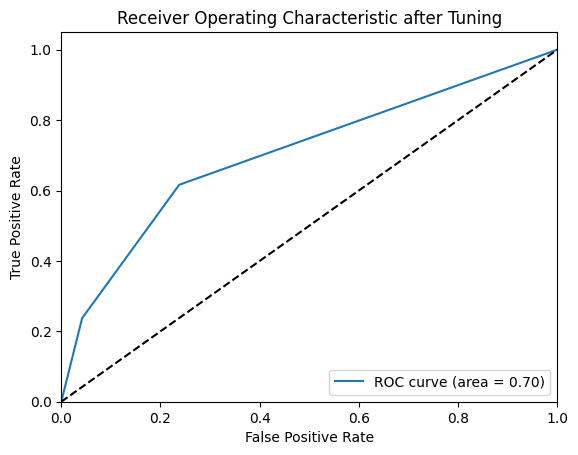

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are already defined

# Training KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Evaluation before tuning
y_pred_knn = knn.predict(X_test)
print("Classification report before tuning:")
print(classification_report(y_test, y_pred_knn))

# Hyperparameters Tuning
param_grid_knn = {'n_neighbors': range(2, 10)}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_
print(f'Best parameters: {grid_search_knn.best_params_}')

# Evaluation after tuning
y_pred_knn_tuned = best_knn.predict(X_test)
print("Classification report after tuning:")
print(classification_report(y_test, y_pred_knn_tuned))

# Compute ROC AUC score for the tuned model
y_pred_prob_knn_tuned = best_knn.predict_proba(X_test)[:, 1]
roc_auc_knn_tuned = roc_auc_score(y_test, y_pred_prob_knn_tuned)
print(f"ROC AUC Score after tuning: {roc_auc_knn_tuned}")

# Plot ROC Curve for the tuned model
fpr_knn_tuned, tpr_knn_tuned, _ = roc_curve(y_test, y_pred_prob_knn_tuned)
plt.figure()
plt.plot(fpr_knn_tuned, tpr_knn_tuned, label='ROC curve (area = %0.2f)' % roc_auc_knn_tuned)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic after Tuning')
plt.legend(loc="lower right")
plt.show()


## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are already defined

# Training SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Evaluation before tuning
y_pred_svm = svm.predict(X_test)
print("Classification report before tuning:")
print(classification_report(y_test, y_pred_svm))

# Hyperparameters Tuning
param_grid_svm = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=2)
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_
print(f'Best parameters: {grid_search_svm.best_params_}')

# Evaluation after tuning
y_pred_svm_tuned = best_svm.predict(X_test)
print("Classification report after tuning:")
print(classification_report(y_test, y_pred_svm_tuned))

# Compute ROC AUC score for the tuned model
y_pred_prob_svm_tuned = best_svm.predict_proba(X_test)[:, 1]
roc_auc_svm_tuned = roc_auc_score(y_test, y_pred_prob_svm_tuned)
print(f"ROC AUC Score after tuning: {roc_auc_svm_tuned}")

# Plot ROC Curve for the tuned model
fpr_svm_tuned, tpr_svm_tuned, _ = roc_curve(y_test, y_pred_prob_svm_tuned)
plt.figure()
plt.plot(fpr_svm_tuned, tpr_svm_tuned, label='ROC curve (area = %0.2f)' % roc_auc_svm_tuned)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic after Tuning')
plt.legend(loc="lower right")
plt.show()

## Handling Imbalanced Data

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Oversampling
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Undersampling
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Train and evaluate models on the balanced dataset

### Logistic

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Training Logistic Regression on the balanced dataset
log_reg_smote = LogisticRegression()
log_reg_smote.fit(X_train_smote, y_train_smote)

# Evaluation
y_pred_log_reg_smote = log_reg_smote.predict(X_test)
print(classification_report(y_test, y_pred_log_reg_smote))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     22672
           1       0.62      0.60      0.61      6420

    accuracy                           0.83     29092
   macro avg       0.75      0.75      0.75     29092
weighted avg       0.83      0.83      0.83     29092



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Training KNN on the balanced dataset
knn_smote = KNeighborsClassifier()
knn_smote.fit(X_train_smote, y_train_smote)

# Evaluation
y_pred_knn_smote = knn_smote.predict(X_test)
print(classification_report(y_test, y_pred_knn_smote))

              precision    recall  f1-score   support

           0       0.89      0.62      0.73     22672
           1       0.35      0.74      0.48      6420

    accuracy                           0.64     29092
   macro avg       0.62      0.68      0.60     29092
weighted avg       0.77      0.64      0.67     29092



### SVM

In [ ]:
from sklearn.svm import SVC

# Training SVM on the balanced dataset
svm_smote = SVC()
svm_smote.fit(X_train_smote, y_train_smote)

# Evaluation
y_pred_svm_smote = svm_smote.predict(X_test)
print(classification_report(y_test, y_pred_svm_smote))


              precision    recall  f1-score   support

           0       0.89      0.91      0.90     22672
           1       0.66      0.58      0.62      6420

    accuracy                           0.84     29092
   macro avg       0.77      0.75      0.76     29092
weighted avg       0.84      0.84      0.84     29092

